# Fase 1: Information Theory - Validación Híbrida Ventanas

**Objetivo**: Calcular Mutual Information entre features diarias y retornos futuros para identificar días con información predictiva.

**Método**: Information Theory (model-agnostic)
- Mutual Information I(X_t; y) por día relativo
- Filtrado rápido: descarta días sin señal
- Solo usa columnas básicas de DIB bars

**Output**: `phase1_results.pkl` con info_results por evento

**Tiempo estimado**: 10-20 min (con sample_size=200)

## 0. Setup

In [1]:
import polars as pl
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score
import pickle
import warnings
warnings.filterwarnings('ignore')

# Config
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Paths
BARS_ROOT = Path('../../../../processed/dib_bars/pilot50_validation')
WATCHLIST = Path('../../../../processed/universe/pilot50_validation/daily')
OUTPUT_DIR = Path('.')

print(f"DIB bars dir exists: {BARS_ROOT.exists()}")
print(f"Watchlist exists: {WATCHLIST.exists()}")
print(f"Output dir: {OUTPUT_DIR.absolute()}")

DIB bars dir exists: True
Watchlist exists: True
Output dir: D:\04_TRADING_SMALLCAPS\01_DayBook\fase_01\F_Event_detectors_E1_E11\notebooks


## 1. Cargar Watchlist con Eventos

In [2]:
# Cargar todos los watchlists particionados por fecha
watchlist_files = list(WATCHLIST.rglob('watchlist.parquet'))
print(f"Encontrados {len(watchlist_files):,} watchlist files")

wl_parts = []
for wl_file in watchlist_files:
    # Extract date from path: date=YYYY-MM-DD/watchlist.parquet
    date_str = wl_file.parent.name.split('=')[1]
    df = pl.read_parquet(wl_file)
    df = df.with_columns([pl.lit(date_str).alias('date')])
    wl_parts.append(df)

wl = pl.concat(wl_parts)
print(f"Total watchlist rows: {wl.height:,}")

# Convertir date a pl.Date
wl = wl.with_columns([
    pl.col('date').str.strptime(pl.Date, format='%Y-%m-%d')
])

# Expandir una fila por evento
wl_expanded = wl.explode('events').rename({'events': 'event_code'})
print(f"Total event occurrences: {wl_expanded.height:,}")

# Eventos disponibles
events_available = sorted(wl_expanded['event_code'].unique().to_list())
print(f"\nEventos disponibles: {events_available}")

wl_expanded.head()

Encontrados 5,579 watchlist files


Total watchlist rows: 37,274
Total event occurrences: 44,795

Eventos disponibles: ['E10_FirstGreenBounce', 'E11_VolumeBounce', 'E1_VolExplosion', 'E2_GapUp', 'E3_PriceSpikeIntraday', 'E4_Parabolic', 'E5_BreakoutATH', 'E6_MultipleGreenDays', 'E7_FirstRedDay', 'E8_GapDownViolent', 'E9_CrashIntraday']


ticker,date,event_code,event_count,info_rich
str,date,str,u32,bool
"""AGM""",2004-01-02,"""E5_BreakoutATH""",1,true
"""DCTH""",2004-01-02,"""E5_BreakoutATH""",1,true
"""DSE""",2004-01-02,"""E5_BreakoutATH""",1,true
"""IDT""",2004-01-02,"""E5_BreakoutATH""",1,true
"""LPSN""",2004-01-02,"""E5_BreakoutATH""",1,true


## 2. Funciones de Información Mutua

In [3]:
def load_dib_bars_day(ticker: str, day: datetime.date) -> pl.DataFrame:
    """
    Carga DIB bars de un ticker en un día específico.
    """
    bars_file = BARS_ROOT / ticker / f"date={day.isoformat()}" / "dollar_imbalance.parquet"
    if not bars_file.exists():
        return None
    return pl.read_parquet(bars_file)


def aggregate_day_features(df_bars: pl.DataFrame) -> dict:
    """
    Agrega features intradía de DIB bars a features diarias.
    Solo usa columnas básicas: o, h, l, c, v, n, dollar, imbalance_score
    """
    if df_bars is None or df_bars.height == 0:
        return None
    
    # Calcular features agregados del día
    agg = df_bars.select([
        ((pl.col('c') - pl.col('o')) / pl.col('o')).mean().alias('ret_day'),
        ((pl.col('h') - pl.col('l')) / pl.col('o')).mean().alias('range_day'),
        pl.col('v').sum().alias('vol_day'),
        pl.col('dollar').sum().alias('dollar_day'),
        pl.col('imbalance_score').mean().alias('imb_day'),
        pl.col('n').sum().alias('n_bars')
    ])
    
    return agg.to_dicts()[0] if agg.height > 0 else None


def calculate_mutual_information_discretized(
    X: np.ndarray,
    y: np.ndarray,
    bins: int = 10
) -> float:
    """
    Calcula mutual information promedio entre features X y target y.
    """
    y_binned = pd.cut(y, bins=bins, labels=False, duplicates='drop')
    
    mi_scores = []
    for col_idx in range(X.shape[1]):
        x_col = X[:, col_idx]
        x_binned = pd.cut(x_col, bins=bins, labels=False, duplicates='drop')
        
        valid_mask = ~(pd.isna(x_binned) | pd.isna(y_binned))
        if valid_mask.sum() > 10:
            mi = mutual_info_score(x_binned[valid_mask], y_binned[valid_mask])
            mi_scores.append(mi)
    
    return np.mean(mi_scores) if mi_scores else 0.0


print("✓ Funciones de información mutua definidas")

✓ Funciones de información mutua definidas


## 3. Calcular MI por Día Relativo

In [4]:
def analyze_information_by_relative_day(
    event_code: str,
    max_pre: int = 7,
    max_post: int = 7,
    sample_size: int = 500
) -> dict:
    """
    Para un evento, calcula I(X_t; y) para cada día t relativo al evento.
    
    Returns:
        {rel_day: mutual_information_score}
    """
    # Filtrar eventos de este tipo
    subset = wl_expanded.filter(pl.col('event_code') == event_code)
    
    # Sample para acelerar (opcional)
    if subset.height > sample_size:
        subset = subset.sample(sample_size, seed=42)
    
    print(f"\nAnalizando {event_code}: {subset.height} ocurrencias")
    
    # Recolectar datos por día relativo
    data_by_day = {}
    
    for rel_day in range(-max_pre, max_post + 1):
        features_list = []
        targets_list = []
        
        for row in subset.iter_rows(named=True):
            ticker = row['ticker']
            t0 = row['date']
            
            # Día relativo actual
            d = t0 + timedelta(days=rel_day)
            bars = load_dib_bars_day(ticker, d)
            
            if bars is None or bars.height == 0:
                continue
            
            # Features agregados del día
            feat = aggregate_day_features(bars)
            if feat is None:
                continue
            
            # Target: retorno futuro desde t0 (día evento)
            # Usamos bars del día t0+1, t0+2, t0+3 para calcular ret_3d
            bars_t0 = load_dib_bars_day(ticker, t0)
            bars_t3 = load_dib_bars_day(ticker, t0 + timedelta(days=3))
            
            if bars_t0 is None or bars_t3 is None:
                continue
            if bars_t0.height == 0 or bars_t3.height == 0:
                continue
            
            # Calcular retorno 3d
            p0 = bars_t0['c'][-1]
            p3 = bars_t3['c'][-1]
            ret_3d = (p3 - p0) / p0
            
            features_list.append(list(feat.values()))
            targets_list.append(ret_3d)
        
        if len(features_list) < 50:
            data_by_day[rel_day] = 0.0
            continue
        
        X = np.array(features_list)
        y = np.array(targets_list)
        
        # Calcular MI
        mi = calculate_mutual_information_discretized(X, y, bins=10)
        data_by_day[rel_day] = mi
        
        print(f"  t={rel_day:+d}: MI={mi:.4f} (n={len(features_list)})")
    
    return data_by_day


print("✓ Función de análisis por día relativo definida")

✓ Función de análisis por día relativo definida


## 4. Ejecutar Análisis Information Theory

**NOTA**: Ajusta `EVENTS_TO_TEST` según necesites:
- `[:3]` → Prueba rápida (3 eventos, ~10-15 min)
- Sin slice → Análisis completo (11 eventos, ~40-60 min)

In [5]:
# CONFIGURACIÓN: Ajusta aquí el subset de eventos
EVENTS_TO_TEST = events_available[:3]  # Cambiar a events_available para análisis completo
MAX_PRE_DAYS = 3
MAX_POST_DAYS = 3
SAMPLE_SIZE = 200  # Reducir a 100 para más velocidad, aumentar a 500 para más precisión

print(f"Analizando {len(EVENTS_TO_TEST)} eventos con ventana [{-MAX_PRE_DAYS}, {MAX_POST_DAYS}]")
print(f"Sample size: {SAMPLE_SIZE} ocurrencias por evento\n")

info_results = {}

for event in EVENTS_TO_TEST:
    info_by_day = analyze_information_by_relative_day(
        event,
        max_pre=MAX_PRE_DAYS,
        max_post=MAX_POST_DAYS,
        sample_size=SAMPLE_SIZE
    )
    info_results[event] = info_by_day

print("\n" + "="*60)
print("✓ Análisis Information Theory completado")
print(f"Eventos analizados: {len(info_results)}")
print("="*60)

Analizando 3 eventos con ventana [-3, 3]
Sample size: 200 ocurrencias por evento


Analizando E10_FirstGreenBounce: 200 ocurrencias


  t=-3: MI=0.2667 (n=76)


  t=-1: MI=0.2883 (n=71)


  t=+0: MI=0.1473 (n=120)


  t=+1: MI=0.1965 (n=86)


  t=+2: MI=0.2386 (n=84)


  t=+3: MI=0.2119 (n=120)

Analizando E11_VolumeBounce: 200 ocurrencias


  t=-3: MI=0.0587 (n=69)


  t=-1: MI=0.0229 (n=78)


  t=+0: MI=0.0439 (n=116)


  t=+1: MI=0.0377 (n=81)


  t=+2: MI=0.0280 (n=81)


  t=+3: MI=0.0336 (n=116)

Analizando E1_VolExplosion: 200 ocurrencias


  t=-3: MI=0.1826 (n=71)


  t=-1: MI=0.1403 (n=69)


  t=+0: MI=0.1561 (n=108)


  t=+1: MI=0.2625 (n=73)


  t=+2: MI=0.2873 (n=70)


  t=+3: MI=0.1843 (n=108)

✓ Análisis Information Theory completado
Eventos analizados: 3


## 5. Visualizar Información por Día

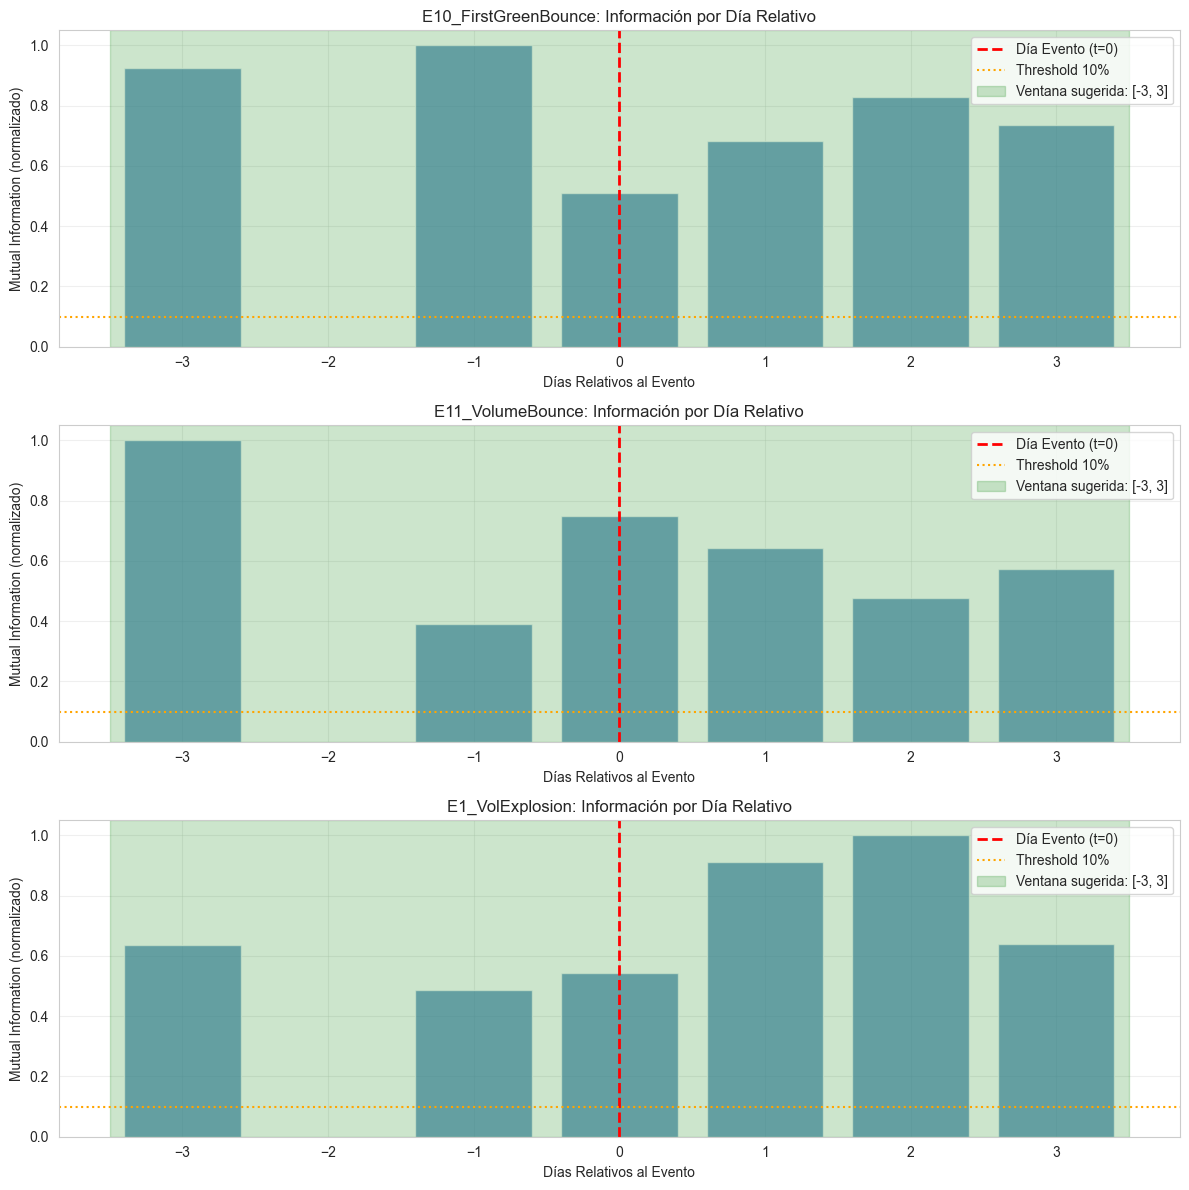

✓ Gráfico guardado: information_by_day_phase1.png


In [6]:
fig, axes = plt.subplots(len(info_results), 1, figsize=(12, 4 * len(info_results)))

if len(info_results) == 1:
    axes = [axes]

for idx, (event, info_by_day) in enumerate(info_results.items()):
    ax = axes[idx]
    
    days = sorted(info_by_day.keys())
    mi_scores = [info_by_day[d] for d in days]
    
    # Normalizar
    max_mi = max(mi_scores) if max(mi_scores) > 0 else 1.0
    mi_norm = [m / max_mi for m in mi_scores]
    
    # Plot
    ax.bar(days, mi_norm, alpha=0.7, color='steelblue')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Día Evento (t=0)')
    ax.axhline(y=0.1, color='orange', linestyle=':', label='Threshold 10%')
    
    # Marcar días significativos
    significant_days = [d for d, mi in zip(days, mi_norm) if mi >= 0.1]
    if significant_days:
        t_start, t_end = min(significant_days), max(significant_days)
        ax.axvspan(t_start - 0.5, t_end + 0.5, alpha=0.2, color='green',
                   label=f'Ventana sugerida: [{t_start}, {t_end}]')
    
    ax.set_xlabel('Días Relativos al Evento')
    ax.set_ylabel('Mutual Information (normalizado)')
    ax.set_title(f'{event}: Información por Día Relativo')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('information_by_day_phase1.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: information_by_day_phase1.png")

## 6. Resumen: Ventanas Sugeridas por MI

In [7]:
print("\n" + "="*80)
print("VENTANAS SUGERIDAS POR MUTUAL INFORMATION (threshold 10%)")
print("="*80)

suggested_windows = {}

for event, info_by_day in info_results.items():
    days = sorted(info_by_day.keys())
    mi_scores = [info_by_day[d] for d in days]
    max_mi = max(mi_scores) if max(mi_scores) > 0 else 1.0
    mi_norm = [m / max_mi for m in mi_scores]
    significant_days = [d for d, mi in zip(days, mi_norm) if mi >= 0.1]
    
    if significant_days:
        window = (min(significant_days), max(significant_days))
        suggested_windows[event] = window
        print(f"  {event:<25} → [{window[0]:+d}, {window[1]:+d}]")
    else:
        suggested_windows[event] = None
        print(f"  {event:<25} → Sin ventana clara (MI muy bajo)")

print("="*80)


VENTANAS SUGERIDAS POR MUTUAL INFORMATION (threshold 10%)
  E10_FirstGreenBounce      → [-3, +3]
  E11_VolumeBounce          → [-3, +3]
  E1_VolExplosion           → [-3, +3]


## 7. Guardar Resultados Fase 1

**Output**: `phase1_results.pkl` con todos los datos necesarios para Fase 2

In [8]:
# Empaquetar resultados
results_phase1 = {
    'info_results': info_results,
    'wl_expanded': wl_expanded,
    'events_available': events_available,
    'suggested_windows': suggested_windows,
    'config': {
        'max_pre_days': MAX_PRE_DAYS,
        'max_post_days': MAX_POST_DAYS,
        'sample_size': SAMPLE_SIZE,
        'events_tested': EVENTS_TO_TEST
    }
}

# Guardar a disco
output_file = OUTPUT_DIR / 'phase1_results.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(results_phase1, f)

print("\n" + "="*80)
print("✓ FASE 1 COMPLETADA")
print("="*80)
print(f"Resultados guardados en: {output_file.absolute()}")
print(f"\nContenido:")
print(f"  - info_results: {len(info_results)} eventos con MI por día relativo")
print(f"  - wl_expanded: {wl_expanded.height:,} event occurrences")
print(f"  - events_available: {len(events_available)} eventos totales")
print(f"  - suggested_windows: {len([w for w in suggested_windows.values() if w])} ventanas sugeridas")
print(f"\nPróximo paso: Ejecutar phase2_model_performance.ipynb")
print("="*80)


✓ FASE 1 COMPLETADA
Resultados guardados en: D:\04_TRADING_SMALLCAPS\01_DayBook\fase_01\F_Event_detectors_E1_E11\notebooks\phase1_results.pkl

Contenido:
  - info_results: 3 eventos con MI por día relativo
  - wl_expanded: 44,795 event occurrences
  - events_available: 11 eventos totales
  - suggested_windows: 3 ventanas sugeridas

Próximo paso: Ejecutar phase2_model_performance.ipynb


In [9]:
def export_events_for_tradingview(event_code: str, output_dir: Path = Path('.')):
    """
    Exporta eventos con timestamps exactos para visualización en TradingView.
    
    Para cada evento crea CSV con:
    - ticker
    - datetime (timestamp exacto del primer bar del evento)
    - close_price (precio en el momento del evento)
    - event_code
    - window_suggested (ventana sugerida por MI)
    """
    # Filtrar eventos de este tipo
    subset = wl_expanded.filter(pl.col('event_code') == event_code)
    
    print(f"\nProcesando {event_code}: {subset.height:,} ocurrencias")
    
    events_data = []
    
    for idx, row in enumerate(subset.iter_rows(named=True)):
        ticker = row['ticker']
        event_date = row['date']
        
        # Cargar DIB bars del día del evento para obtener timestamp exacto
        bars = load_dib_bars_day(ticker, event_date)
        
        if bars is None or bars.height == 0:
            continue
        
        # Timestamp del PRIMER bar del evento (inicio de la sesión)
        first_ts = bars['t_open'][0]  # Timestamp de apertura del primer bar
        close_price = bars['c'][0]  # Precio de cierre del primer bar
        
        # Ventana sugerida
        window = suggested_windows.get(event_code, None)
        window_str = f"[{window[0]:+d},{window[1]:+d}]" if window else "N/A"
        
        events_data.append({
            'ticker': ticker,
            'datetime': first_ts,
            'close_price': close_price,
            'event_code': event_code,
            'window_suggested': window_str,
            'date': event_date
        })
        
        # Progress cada 100 eventos
        if (idx + 1) % 100 == 0:
            print(f"  Procesados {idx + 1:,} / {subset.height:,} eventos...")
    
    if not events_data:
        print(f"⚠️  No se encontraron datos para {event_code}")
        return None
    
    # Crear DataFrame
    df = pd.DataFrame(events_data)
    
    # Ordenar por datetime
    df = df.sort_values('datetime')
    
    # Exportar CSV
    output_file = output_dir / f'tradingview_{event_code}.csv'
    df.to_csv(output_file, index=False)
    
    print(f"✓ Exportado: {output_file}")
    print(f"  Total eventos: {len(df):,}")
    print(f"  Tickers únicos: {df['ticker'].nunique()}")
    print(f"  Rango fechas: {df['date'].min()} a {df['date'].max()}")
    print(f"  Ventana sugerida: {window_str}")
    
    return df


# Crear directorio para exports
TRADINGVIEW_DIR = OUTPUT_DIR / 'tradingview_exports'
TRADINGVIEW_DIR.mkdir(exist_ok=True)

print("="*80)
print("EXPORTANDO EVENTOS PARA TRADINGVIEW")
print("="*80)

all_exports = {}

# Exportar TODOS los eventos disponibles (no solo los analizados)
for event in events_available:
    df = export_events_for_tradingview(event, TRADINGVIEW_DIR)
    if df is not None:
        all_exports[event] = df

print("\n" + "="*80)
print("✓ EXPORTACIÓN COMPLETADA")
print("="*80)
print(f"Directorio: {TRADINGVIEW_DIR.absolute()}")
print(f"Archivos generados: {len(all_exports)}")
print(f"\nEventos exportados:")
for event, df in all_exports.items():
    print(f"  • {event:<30} → {len(df):>6,} ocurrencias")
print("="*80)

print("\n📊 CÓMO USAR EN TRADINGVIEW:")
print("1. Abre TradingView con el ticker que quieres analizar")
print("2. Importa el CSV correspondiente como 'Custom Indicator'")
print("3. Los eventos aparecerán como marcadores en el gráfico")
print("4. Filtra por ticker si el CSV contiene múltiples símbolos")
print("\nEjemplo: Para ver E10_FirstGreenBounce en ticker AAPL:")
print(f"  → Carga: {TRADINGVIEW_DIR / 'tradingview_E10_FirstGreenBounce.csv'}")
print("  → Filtra columna 'ticker' = 'AAPL'")

EXPORTANDO EVENTOS PARA TRADINGVIEW

Procesando E10_FirstGreenBounce: 8,520 ocurrencias


  Procesados 100 / 8,520 eventos...


  Procesados 200 / 8,520 eventos...


  Procesados 300 / 8,520 eventos...


  Procesados 400 / 8,520 eventos...


  Procesados 500 / 8,520 eventos...


  Procesados 600 / 8,520 eventos...


  Procesados 700 / 8,520 eventos...


  Procesados 800 / 8,520 eventos...


  Procesados 900 / 8,520 eventos...


  Procesados 1,000 / 8,520 eventos...


  Procesados 1,100 / 8,520 eventos...


  Procesados 1,200 / 8,520 eventos...


  Procesados 1,300 / 8,520 eventos...


  Procesados 1,400 / 8,520 eventos...


  Procesados 1,500 / 8,520 eventos...


  Procesados 1,600 / 8,520 eventos...


  Procesados 1,700 / 8,520 eventos...


  Procesados 1,800 / 8,520 eventos...


  Procesados 1,900 / 8,520 eventos...


  Procesados 2,000 / 8,520 eventos...


  Procesados 2,100 / 8,520 eventos...


  Procesados 2,200 / 8,520 eventos...


  Procesados 2,300 / 8,520 eventos...


  Procesados 2,400 / 8,520 eventos...


  Procesados 2,500 / 8,520 eventos...


  Procesados 2,600 / 8,520 eventos...


  Procesados 2,700 / 8,520 eventos...


  Procesados 2,800 / 8,520 eventos...


  Procesados 2,900 / 8,520 eventos...


  Procesados 3,000 / 8,520 eventos...


  Procesados 3,100 / 8,520 eventos...


  Procesados 3,200 / 8,520 eventos...


  Procesados 3,300 / 8,520 eventos...


  Procesados 3,400 / 8,520 eventos...


  Procesados 3,500 / 8,520 eventos...


  Procesados 3,600 / 8,520 eventos...


  Procesados 3,700 / 8,520 eventos...


  Procesados 3,800 / 8,520 eventos...


  Procesados 3,900 / 8,520 eventos...


  Procesados 4,000 / 8,520 eventos...


  Procesados 4,100 / 8,520 eventos...


  Procesados 4,200 / 8,520 eventos...


  Procesados 4,300 / 8,520 eventos...


  Procesados 4,400 / 8,520 eventos...


  Procesados 4,500 / 8,520 eventos...


  Procesados 4,600 / 8,520 eventos...


  Procesados 4,700 / 8,520 eventos...


  Procesados 4,800 / 8,520 eventos...


  Procesados 4,900 / 8,520 eventos...


  Procesados 5,000 / 8,520 eventos...


  Procesados 5,100 / 8,520 eventos...


  Procesados 5,200 / 8,520 eventos...


  Procesados 5,300 / 8,520 eventos...


  Procesados 5,400 / 8,520 eventos...


  Procesados 5,500 / 8,520 eventos...


  Procesados 5,600 / 8,520 eventos...


  Procesados 5,700 / 8,520 eventos...


  Procesados 5,800 / 8,520 eventos...


  Procesados 5,900 / 8,520 eventos...


  Procesados 6,000 / 8,520 eventos...


  Procesados 6,100 / 8,520 eventos...


  Procesados 6,200 / 8,520 eventos...


  Procesados 6,300 / 8,520 eventos...


  Procesados 6,400 / 8,520 eventos...


  Procesados 6,500 / 8,520 eventos...


  Procesados 6,600 / 8,520 eventos...


  Procesados 6,700 / 8,520 eventos...


  Procesados 6,800 / 8,520 eventos...


  Procesados 6,900 / 8,520 eventos...


  Procesados 7,000 / 8,520 eventos...


  Procesados 7,100 / 8,520 eventos...


  Procesados 7,200 / 8,520 eventos...


  Procesados 7,300 / 8,520 eventos...


  Procesados 7,400 / 8,520 eventos...


  Procesados 7,500 / 8,520 eventos...


  Procesados 7,600 / 8,520 eventos...


  Procesados 7,700 / 8,520 eventos...


  Procesados 7,800 / 8,520 eventos...


  Procesados 7,900 / 8,520 eventos...


  Procesados 8,000 / 8,520 eventos...


  Procesados 8,100 / 8,520 eventos...


  Procesados 8,200 / 8,520 eventos...


  Procesados 8,300 / 8,520 eventos...


  Procesados 8,400 / 8,520 eventos...


  Procesados 8,500 / 8,520 eventos...


✓ Exportado: tradingview_exports\tradingview_E10_FirstGreenBounce.csv
  Total eventos: 8,493
  Tickers únicos: 50
  Rango fechas: 2004-01-08 a 2025-10-21
  Ventana sugerida: [-3,+3]

Procesando E11_VolumeBounce: 1,282 ocurrencias


  Procesados 100 / 1,282 eventos...


  Procesados 200 / 1,282 eventos...


  Procesados 300 / 1,282 eventos...


  Procesados 400 / 1,282 eventos...


  Procesados 500 / 1,282 eventos...


  Procesados 600 / 1,282 eventos...


  Procesados 700 / 1,282 eventos...


  Procesados 800 / 1,282 eventos...


  Procesados 900 / 1,282 eventos...


  Procesados 1,000 / 1,282 eventos...


  Procesados 1,100 / 1,282 eventos...


  Procesados 1,200 / 1,282 eventos...


✓ Exportado: tradingview_exports\tradingview_E11_VolumeBounce.csv
  Total eventos: 1,255
  Tickers únicos: 50
  Rango fechas: 2004-01-30 a 2025-09-10
  Ventana sugerida: [-3,+3]

Procesando E1_VolExplosion: 7,837 ocurrencias


  Procesados 100 / 7,837 eventos...


  Procesados 200 / 7,837 eventos...


  Procesados 300 / 7,837 eventos...


  Procesados 400 / 7,837 eventos...


  Procesados 500 / 7,837 eventos...


  Procesados 600 / 7,837 eventos...


  Procesados 700 / 7,837 eventos...


  Procesados 800 / 7,837 eventos...


  Procesados 900 / 7,837 eventos...


  Procesados 1,000 / 7,837 eventos...


  Procesados 1,100 / 7,837 eventos...


  Procesados 1,200 / 7,837 eventos...


  Procesados 1,300 / 7,837 eventos...


  Procesados 1,400 / 7,837 eventos...


  Procesados 1,500 / 7,837 eventos...


  Procesados 1,600 / 7,837 eventos...


  Procesados 1,700 / 7,837 eventos...


  Procesados 1,800 / 7,837 eventos...


  Procesados 1,900 / 7,837 eventos...


  Procesados 2,000 / 7,837 eventos...


  Procesados 2,100 / 7,837 eventos...


  Procesados 2,200 / 7,837 eventos...


  Procesados 2,300 / 7,837 eventos...


  Procesados 2,400 / 7,837 eventos...


  Procesados 2,500 / 7,837 eventos...


  Procesados 2,600 / 7,837 eventos...


  Procesados 2,700 / 7,837 eventos...


  Procesados 2,800 / 7,837 eventos...


  Procesados 2,900 / 7,837 eventos...


  Procesados 3,000 / 7,837 eventos...


  Procesados 3,100 / 7,837 eventos...


  Procesados 3,200 / 7,837 eventos...


  Procesados 3,300 / 7,837 eventos...


  Procesados 3,400 / 7,837 eventos...


  Procesados 3,500 / 7,837 eventos...


  Procesados 3,600 / 7,837 eventos...


  Procesados 3,700 / 7,837 eventos...


  Procesados 3,800 / 7,837 eventos...


  Procesados 3,900 / 7,837 eventos...


  Procesados 4,000 / 7,837 eventos...


  Procesados 4,100 / 7,837 eventos...


  Procesados 4,200 / 7,837 eventos...


  Procesados 4,300 / 7,837 eventos...


  Procesados 4,400 / 7,837 eventos...


  Procesados 4,500 / 7,837 eventos...


  Procesados 4,600 / 7,837 eventos...


  Procesados 4,700 / 7,837 eventos...


  Procesados 4,800 / 7,837 eventos...


  Procesados 4,900 / 7,837 eventos...


  Procesados 5,000 / 7,837 eventos...


  Procesados 5,100 / 7,837 eventos...


  Procesados 5,200 / 7,837 eventos...


  Procesados 5,300 / 7,837 eventos...


  Procesados 5,400 / 7,837 eventos...


  Procesados 5,500 / 7,837 eventos...


  Procesados 5,600 / 7,837 eventos...


  Procesados 5,700 / 7,837 eventos...


  Procesados 5,800 / 7,837 eventos...


  Procesados 5,900 / 7,837 eventos...


  Procesados 6,000 / 7,837 eventos...


  Procesados 6,100 / 7,837 eventos...


  Procesados 6,200 / 7,837 eventos...


  Procesados 6,300 / 7,837 eventos...


  Procesados 6,400 / 7,837 eventos...


  Procesados 6,500 / 7,837 eventos...


  Procesados 6,600 / 7,837 eventos...


  Procesados 6,700 / 7,837 eventos...


  Procesados 6,800 / 7,837 eventos...


  Procesados 6,900 / 7,837 eventos...


  Procesados 7,000 / 7,837 eventos...


  Procesados 7,100 / 7,837 eventos...


  Procesados 7,200 / 7,837 eventos...


  Procesados 7,300 / 7,837 eventos...


  Procesados 7,400 / 7,837 eventos...


  Procesados 7,600 / 7,837 eventos...


  Procesados 7,700 / 7,837 eventos...


  Procesados 7,800 / 7,837 eventos...


✓ Exportado: tradingview_exports\tradingview_E1_VolExplosion.csv
  Total eventos: 7,685
  Tickers únicos: 50
  Rango fechas: 2004-01-30 a 2025-10-14
  Ventana sugerida: [-3,+3]

Procesando E2_GapUp: 1,085 ocurrencias


  Procesados 100 / 1,085 eventos...


  Procesados 200 / 1,085 eventos...


  Procesados 300 / 1,085 eventos...


  Procesados 400 / 1,085 eventos...


  Procesados 500 / 1,085 eventos...


  Procesados 600 / 1,085 eventos...


  Procesados 700 / 1,085 eventos...


  Procesados 800 / 1,085 eventos...


  Procesados 900 / 1,085 eventos...


  Procesados 1,000 / 1,085 eventos...


✓ Exportado: tradingview_exports\tradingview_E2_GapUp.csv
  Total eventos: 1,069
  Tickers únicos: 50
  Rango fechas: 2004-01-12 a 2025-10-23
  Ventana sugerida: N/A

Procesando E3_PriceSpikeIntraday: 2,074 ocurrencias


  Procesados 100 / 2,074 eventos...


  Procesados 200 / 2,074 eventos...


  Procesados 300 / 2,074 eventos...


  Procesados 400 / 2,074 eventos...


  Procesados 500 / 2,074 eventos...


  Procesados 600 / 2,074 eventos...


  Procesados 700 / 2,074 eventos...


  Procesados 800 / 2,074 eventos...


  Procesados 900 / 2,074 eventos...


  Procesados 1,100 / 2,074 eventos...


  Procesados 1,200 / 2,074 eventos...


  Procesados 1,300 / 2,074 eventos...


  Procesados 1,400 / 2,074 eventos...


  Procesados 1,500 / 2,074 eventos...


  Procesados 1,600 / 2,074 eventos...


  Procesados 1,700 / 2,074 eventos...


  Procesados 1,800 / 2,074 eventos...


  Procesados 1,900 / 2,074 eventos...


  Procesados 2,000 / 2,074 eventos...


✓ Exportado: tradingview_exports\tradingview_E3_PriceSpikeIntraday.csv
  Total eventos: 1,900
  Tickers únicos: 50
  Rango fechas: 2004-01-07 a 2025-10-24
  Ventana sugerida: N/A

Procesando E4_Parabolic: 1,371 ocurrencias


  Procesados 100 / 1,371 eventos...


  Procesados 200 / 1,371 eventos...


  Procesados 300 / 1,371 eventos...


  Procesados 400 / 1,371 eventos...


  Procesados 500 / 1,371 eventos...


  Procesados 700 / 1,371 eventos...


  Procesados 800 / 1,371 eventos...


  Procesados 1,000 / 1,371 eventos...


  Procesados 1,100 / 1,371 eventos...


  Procesados 1,200 / 1,371 eventos...


  Procesados 1,300 / 1,371 eventos...


✓ Exportado: tradingview_exports\tradingview_E4_Parabolic.csv
  Total eventos: 1,264
  Tickers únicos: 49
  Rango fechas: 2004-01-09 a 2025-10-23
  Ventana sugerida: N/A

Procesando E5_BreakoutATH: 4,648 ocurrencias


  Procesados 100 / 4,648 eventos...


  Procesados 200 / 4,648 eventos...


  Procesados 300 / 4,648 eventos...


  Procesados 400 / 4,648 eventos...


  Procesados 500 / 4,648 eventos...


  Procesados 600 / 4,648 eventos...


  Procesados 700 / 4,648 eventos...


  Procesados 800 / 4,648 eventos...


  Procesados 900 / 4,648 eventos...


  Procesados 1,000 / 4,648 eventos...


  Procesados 1,100 / 4,648 eventos...


  Procesados 1,200 / 4,648 eventos...


  Procesados 1,300 / 4,648 eventos...


  Procesados 1,400 / 4,648 eventos...


  Procesados 1,500 / 4,648 eventos...


  Procesados 1,600 / 4,648 eventos...


  Procesados 1,700 / 4,648 eventos...


  Procesados 1,800 / 4,648 eventos...


  Procesados 1,900 / 4,648 eventos...


  Procesados 2,000 / 4,648 eventos...


  Procesados 2,100 / 4,648 eventos...


  Procesados 2,200 / 4,648 eventos...


  Procesados 2,300 / 4,648 eventos...


  Procesados 2,400 / 4,648 eventos...


  Procesados 2,500 / 4,648 eventos...


  Procesados 2,600 / 4,648 eventos...


  Procesados 2,700 / 4,648 eventos...


  Procesados 2,800 / 4,648 eventos...


  Procesados 2,900 / 4,648 eventos...


  Procesados 3,000 / 4,648 eventos...


  Procesados 3,100 / 4,648 eventos...


  Procesados 3,200 / 4,648 eventos...


  Procesados 3,300 / 4,648 eventos...


  Procesados 3,400 / 4,648 eventos...


  Procesados 3,500 / 4,648 eventos...


  Procesados 3,700 / 4,648 eventos...


  Procesados 3,800 / 4,648 eventos...


  Procesados 3,900 / 4,648 eventos...


  Procesados 4,000 / 4,648 eventos...


  Procesados 4,100 / 4,648 eventos...


  Procesados 4,200 / 4,648 eventos...


  Procesados 4,300 / 4,648 eventos...


  Procesados 4,400 / 4,648 eventos...


  Procesados 4,500 / 4,648 eventos...


  Procesados 4,600 / 4,648 eventos...


✓ Exportado: tradingview_exports\tradingview_E5_BreakoutATH.csv
  Total eventos: 4,632
  Tickers únicos: 50
  Rango fechas: 2004-01-02 a 2025-10-21
  Ventana sugerida: N/A

Procesando E6_MultipleGreenDays: 16,817 ocurrencias


  Procesados 100 / 16,817 eventos...


  Procesados 200 / 16,817 eventos...


  Procesados 300 / 16,817 eventos...


  Procesados 400 / 16,817 eventos...


  Procesados 500 / 16,817 eventos...


  Procesados 600 / 16,817 eventos...


  Procesados 700 / 16,817 eventos...


  Procesados 800 / 16,817 eventos...


  Procesados 900 / 16,817 eventos...


  Procesados 1,000 / 16,817 eventos...


  Procesados 1,100 / 16,817 eventos...


  Procesados 1,200 / 16,817 eventos...


  Procesados 1,300 / 16,817 eventos...


  Procesados 1,400 / 16,817 eventos...


  Procesados 1,500 / 16,817 eventos...


  Procesados 1,600 / 16,817 eventos...


  Procesados 1,700 / 16,817 eventos...


  Procesados 1,800 / 16,817 eventos...


  Procesados 1,900 / 16,817 eventos...


  Procesados 2,000 / 16,817 eventos...


  Procesados 2,100 / 16,817 eventos...


  Procesados 2,200 / 16,817 eventos...


  Procesados 2,300 / 16,817 eventos...


  Procesados 2,400 / 16,817 eventos...


  Procesados 2,500 / 16,817 eventos...


  Procesados 2,600 / 16,817 eventos...


  Procesados 2,700 / 16,817 eventos...


  Procesados 2,800 / 16,817 eventos...


  Procesados 2,900 / 16,817 eventos...


  Procesados 3,000 / 16,817 eventos...


  Procesados 3,100 / 16,817 eventos...


  Procesados 3,200 / 16,817 eventos...


  Procesados 3,300 / 16,817 eventos...


  Procesados 3,400 / 16,817 eventos...


  Procesados 3,500 / 16,817 eventos...


  Procesados 3,600 / 16,817 eventos...


  Procesados 3,700 / 16,817 eventos...


  Procesados 3,800 / 16,817 eventos...


  Procesados 3,900 / 16,817 eventos...


  Procesados 4,000 / 16,817 eventos...


  Procesados 4,100 / 16,817 eventos...


  Procesados 4,200 / 16,817 eventos...


  Procesados 4,300 / 16,817 eventos...


  Procesados 4,400 / 16,817 eventos...


  Procesados 4,500 / 16,817 eventos...


  Procesados 4,600 / 16,817 eventos...


  Procesados 4,700 / 16,817 eventos...


  Procesados 4,800 / 16,817 eventos...


  Procesados 4,900 / 16,817 eventos...


  Procesados 5,000 / 16,817 eventos...


  Procesados 5,100 / 16,817 eventos...


  Procesados 5,200 / 16,817 eventos...


  Procesados 5,300 / 16,817 eventos...


  Procesados 5,400 / 16,817 eventos...


  Procesados 5,500 / 16,817 eventos...


  Procesados 5,600 / 16,817 eventos...


  Procesados 5,700 / 16,817 eventos...


  Procesados 5,800 / 16,817 eventos...


  Procesados 5,900 / 16,817 eventos...


  Procesados 6,000 / 16,817 eventos...


  Procesados 6,100 / 16,817 eventos...


  Procesados 6,200 / 16,817 eventos...


  Procesados 6,300 / 16,817 eventos...


  Procesados 6,400 / 16,817 eventos...


  Procesados 6,500 / 16,817 eventos...


  Procesados 6,600 / 16,817 eventos...


  Procesados 6,700 / 16,817 eventos...


  Procesados 6,800 / 16,817 eventos...


  Procesados 6,900 / 16,817 eventos...


  Procesados 7,000 / 16,817 eventos...


  Procesados 7,100 / 16,817 eventos...


  Procesados 7,200 / 16,817 eventos...


  Procesados 7,300 / 16,817 eventos...


  Procesados 7,400 / 16,817 eventos...


  Procesados 7,500 / 16,817 eventos...


  Procesados 7,600 / 16,817 eventos...


  Procesados 7,700 / 16,817 eventos...


  Procesados 7,800 / 16,817 eventos...


  Procesados 7,900 / 16,817 eventos...


  Procesados 8,000 / 16,817 eventos...


  Procesados 8,100 / 16,817 eventos...


  Procesados 8,200 / 16,817 eventos...


  Procesados 8,400 / 16,817 eventos...


  Procesados 8,500 / 16,817 eventos...


  Procesados 8,600 / 16,817 eventos...


  Procesados 8,700 / 16,817 eventos...


  Procesados 8,800 / 16,817 eventos...


  Procesados 8,900 / 16,817 eventos...


  Procesados 9,000 / 16,817 eventos...


  Procesados 9,100 / 16,817 eventos...


  Procesados 9,200 / 16,817 eventos...


  Procesados 9,300 / 16,817 eventos...


  Procesados 9,400 / 16,817 eventos...


  Procesados 9,500 / 16,817 eventos...


  Procesados 9,600 / 16,817 eventos...


  Procesados 9,700 / 16,817 eventos...


  Procesados 9,800 / 16,817 eventos...


  Procesados 9,900 / 16,817 eventos...


  Procesados 10,000 / 16,817 eventos...


  Procesados 10,100 / 16,817 eventos...


  Procesados 10,200 / 16,817 eventos...


  Procesados 10,300 / 16,817 eventos...


  Procesados 10,400 / 16,817 eventos...


  Procesados 10,500 / 16,817 eventos...


  Procesados 10,600 / 16,817 eventos...


  Procesados 10,700 / 16,817 eventos...


  Procesados 10,800 / 16,817 eventos...


  Procesados 10,900 / 16,817 eventos...


  Procesados 11,000 / 16,817 eventos...


  Procesados 11,100 / 16,817 eventos...


  Procesados 11,200 / 16,817 eventos...


  Procesados 11,300 / 16,817 eventos...


  Procesados 11,400 / 16,817 eventos...


  Procesados 11,500 / 16,817 eventos...


  Procesados 11,600 / 16,817 eventos...


  Procesados 11,700 / 16,817 eventos...


  Procesados 11,800 / 16,817 eventos...


  Procesados 11,900 / 16,817 eventos...


  Procesados 12,000 / 16,817 eventos...


  Procesados 12,100 / 16,817 eventos...


  Procesados 12,200 / 16,817 eventos...


  Procesados 12,300 / 16,817 eventos...


  Procesados 12,400 / 16,817 eventos...


  Procesados 12,500 / 16,817 eventos...


  Procesados 12,600 / 16,817 eventos...


  Procesados 12,700 / 16,817 eventos...


  Procesados 12,800 / 16,817 eventos...


  Procesados 12,900 / 16,817 eventos...


  Procesados 13,000 / 16,817 eventos...


  Procesados 13,100 / 16,817 eventos...


  Procesados 13,200 / 16,817 eventos...


  Procesados 13,300 / 16,817 eventos...


  Procesados 13,400 / 16,817 eventos...


  Procesados 13,500 / 16,817 eventos...


  Procesados 13,600 / 16,817 eventos...


  Procesados 13,700 / 16,817 eventos...


  Procesados 13,800 / 16,817 eventos...


  Procesados 13,900 / 16,817 eventos...


  Procesados 14,000 / 16,817 eventos...


  Procesados 14,100 / 16,817 eventos...


  Procesados 14,200 / 16,817 eventos...


  Procesados 14,300 / 16,817 eventos...


  Procesados 14,400 / 16,817 eventos...


  Procesados 14,500 / 16,817 eventos...


  Procesados 14,600 / 16,817 eventos...


  Procesados 14,700 / 16,817 eventos...


  Procesados 14,800 / 16,817 eventos...


  Procesados 14,900 / 16,817 eventos...


  Procesados 15,000 / 16,817 eventos...


  Procesados 15,100 / 16,817 eventos...


  Procesados 15,200 / 16,817 eventos...


  Procesados 15,300 / 16,817 eventos...


  Procesados 15,400 / 16,817 eventos...


  Procesados 15,500 / 16,817 eventos...


  Procesados 15,600 / 16,817 eventos...


  Procesados 15,700 / 16,817 eventos...


  Procesados 15,800 / 16,817 eventos...


  Procesados 15,900 / 16,817 eventos...


  Procesados 16,000 / 16,817 eventos...


  Procesados 16,100 / 16,817 eventos...


  Procesados 16,200 / 16,817 eventos...


  Procesados 16,300 / 16,817 eventos...


  Procesados 16,400 / 16,817 eventos...


  Procesados 16,500 / 16,817 eventos...


  Procesados 16,600 / 16,817 eventos...


  Procesados 16,700 / 16,817 eventos...


  Procesados 16,800 / 16,817 eventos...


✓ Exportado: tradingview_exports\tradingview_E6_MultipleGreenDays.csv
  Total eventos: 16,775
  Tickers únicos: 50
  Rango fechas: 2004-01-07 a 2025-10-23
  Ventana sugerida: N/A

Procesando E7_FirstRedDay: 245 ocurrencias


  Procesados 100 / 245 eventos...


  Procesados 200 / 245 eventos...


✓ Exportado: tradingview_exports\tradingview_E7_FirstRedDay.csv
  Total eventos: 232
  Tickers únicos: 50
  Rango fechas: 2004-01-12 a 2025-10-09
  Ventana sugerida: N/A

Procesando E8_GapDownViolent: 456 ocurrencias


  Procesados 100 / 456 eventos...


  Procesados 200 / 456 eventos...
  Procesados 300 / 456 eventos...


  Procesados 400 / 456 eventos...


✓ Exportado: tradingview_exports\tradingview_E8_GapDownViolent.csv
  Total eventos: 454
  Tickers únicos: 49
  Rango fechas: 2004-03-01 a 2025-10-24
  Ventana sugerida: N/A

Procesando E9_CrashIntraday: 460 ocurrencias


  Procesados 100 / 460 eventos...


  Procesados 200 / 460 eventos...


  Procesados 300 / 460 eventos...


  Procesados 400 / 460 eventos...


✓ Exportado: tradingview_exports\tradingview_E9_CrashIntraday.csv
  Total eventos: 419
  Tickers únicos: 50
  Rango fechas: 2004-07-09 a 2025-10-02
  Ventana sugerida: N/A

✓ EXPORTACIÓN COMPLETADA
Directorio: D:\04_TRADING_SMALLCAPS\01_DayBook\fase_01\F_Event_detectors_E1_E11\notebooks\tradingview_exports
Archivos generados: 11

Eventos exportados:
  • E10_FirstGreenBounce           →  8,493 ocurrencias
  • E11_VolumeBounce               →  1,255 ocurrencias
  • E1_VolExplosion                →  7,685 ocurrencias
  • E2_GapUp                       →  1,069 ocurrencias
  • E3_PriceSpikeIntraday          →  1,900 ocurrencias
  • E4_Parabolic                   →  1,264 ocurrencias
  • E5_BreakoutATH                 →  4,632 ocurrencias
  • E6_MultipleGreenDays           → 16,775 ocurrencias
  • E7_FirstRedDay                 →    232 ocurrencias
  • E8_GapDownViolent              →    454 ocurrencias
  • E9_CrashIntraday               →    419 ocurrencias

📊 CÓMO USAR EN TRADINGVIEW:
1. 

## 10. EXPORTAR EVENTOS PARA TRADINGVIEW

**Objetivo**: Generar CSV con timestamps exactos de TODOS los eventos para visualización en TradingView.

**Formato TradingView**:
- Necesita timestamp exacto (fecha + hora)
- Un archivo por evento
- Columnas: ticker, datetime, event_code, price_at_event

Esto te permitirá:
1. Cargar los eventos como overlays en TradingView
2. Verificar visualmente cada evento sobre el gráfico de precio
3. Validar que la detección fue correcta

## 9. INTERPRETACIÓN: ¿Son creíbles los resultados?

**Criterios de validación:**

1. **Captura de rango > 70%**: La ventana debe contener la mayor parte del movimiento
2. **Volatilidad ratio > 1.5x**: Dentro de ventana debe haber más volatilidad que fuera
3. **Consistencia visual**: Los gráficos deben mostrar patrones claros

**Posibles problemas detectados:**
- Si todas las ventanas son [-3, +3] → Threshold demasiado bajo, MI no discrimina
- Si captura < 50% → Ventana no útil para trading
- Si vol_ratio < 1.0 → Ventana captura el período tranquilo (ERROR)

**Próximos pasos si resultados no son creíbles:**
1. Ajustar threshold de MI (probar 30%, 50% en lugar de 10%)
2. Usar MI absoluto en lugar de normalizado
3. Comparar con Phase 2 (LightGBM) para validación cruzada


VALIDACIÓN VISUAL: Captura de Movimiento Real


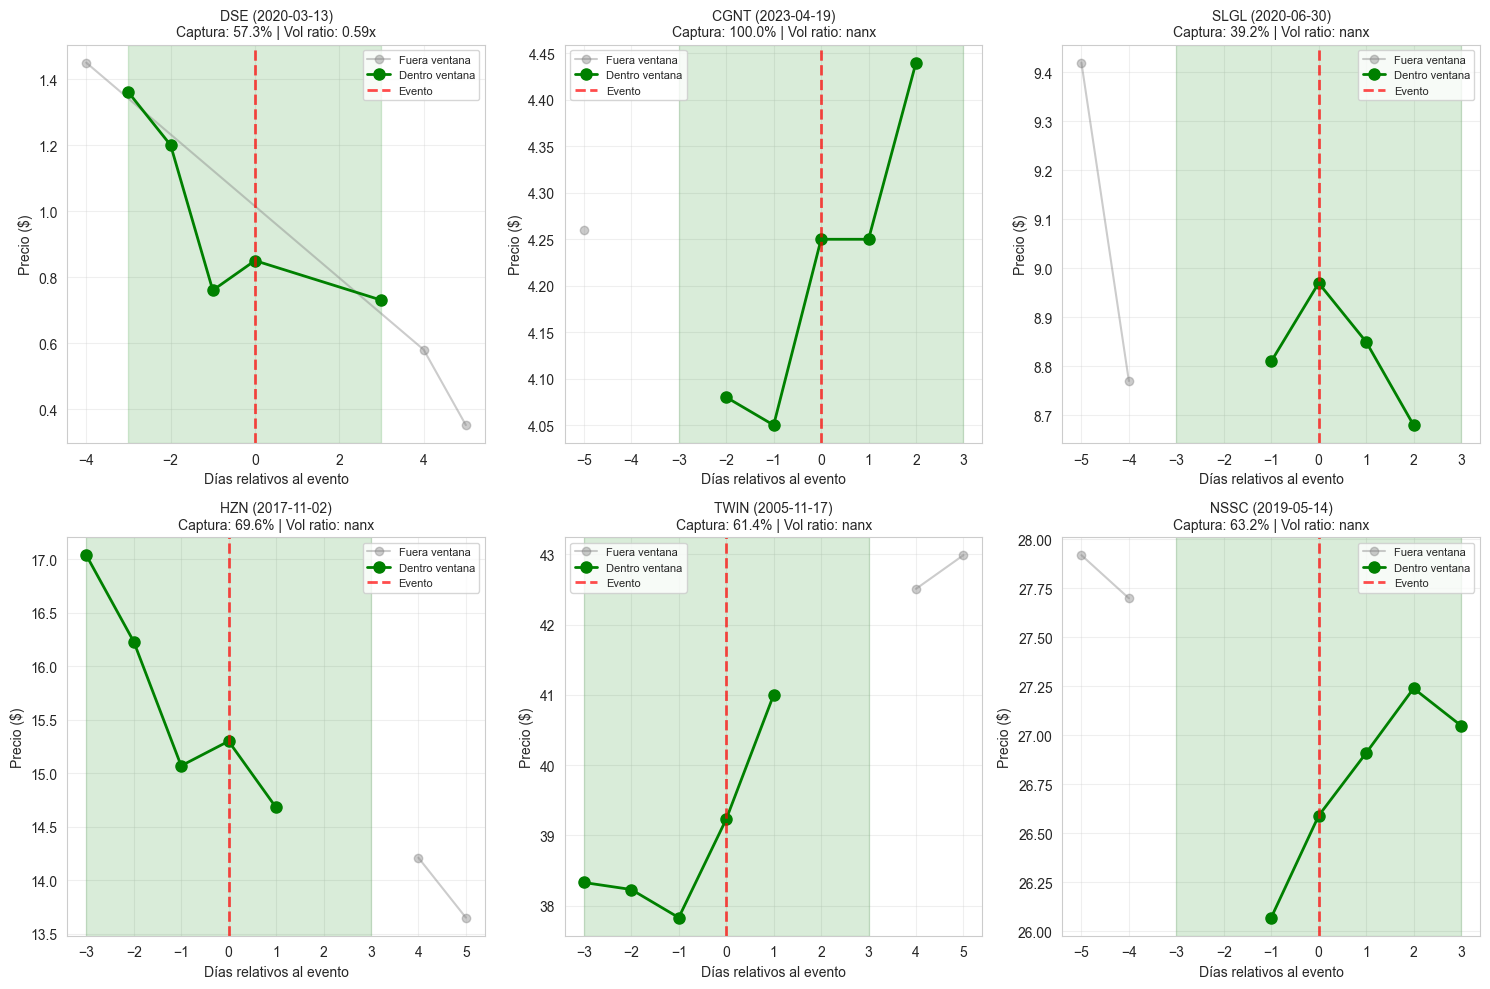


ESTADÍSTICAS DE CAPTURA: E10_FirstGreenBounce
Ventana sugerida: [-3, +3]
  Captura de rango (%):
    - Media:   65.1%
    - Mediana: 62.3%
    - Min:     39.2%
    - Max:     100.0%

  Volatilidad dentro/fuera:
    - Media:   0.59x
    - Mediana: 0.59x

✓ Gráfico guardado: validation_E10_FirstGreenBounce.png



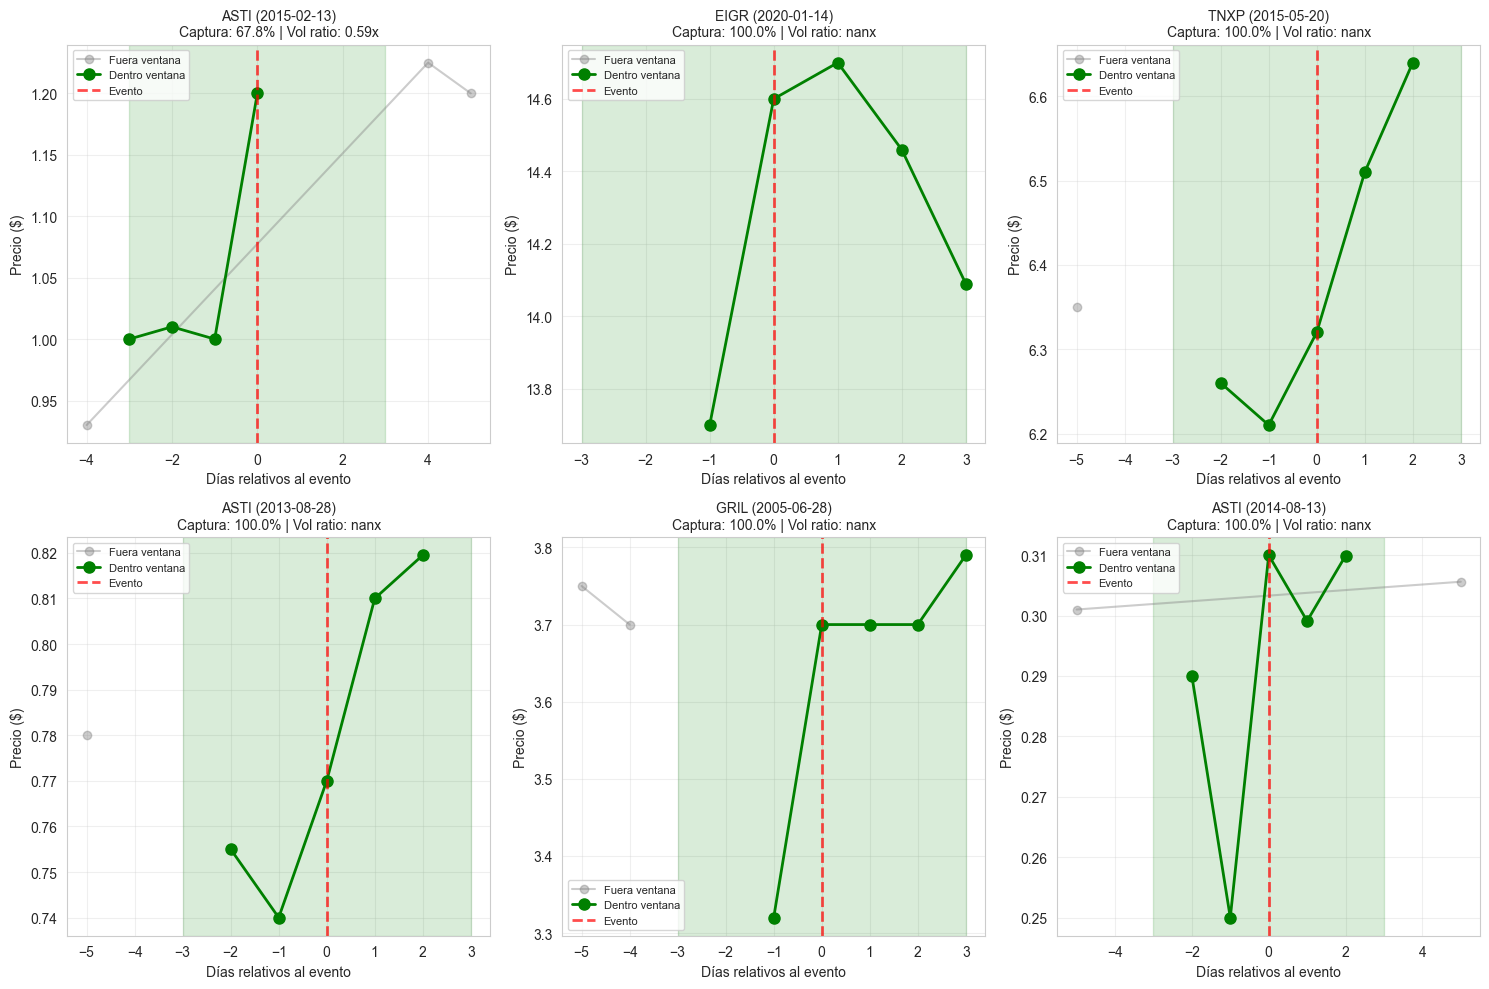


ESTADÍSTICAS DE CAPTURA: E11_VolumeBounce
Ventana sugerida: [-3, +3]
  Captura de rango (%):
    - Media:   94.6%
    - Mediana: 100.0%
    - Min:     67.8%
    - Max:     100.0%

  Volatilidad dentro/fuera:
    - Media:   0.59x
    - Mediana: 0.59x

✓ Gráfico guardado: validation_E11_VolumeBounce.png



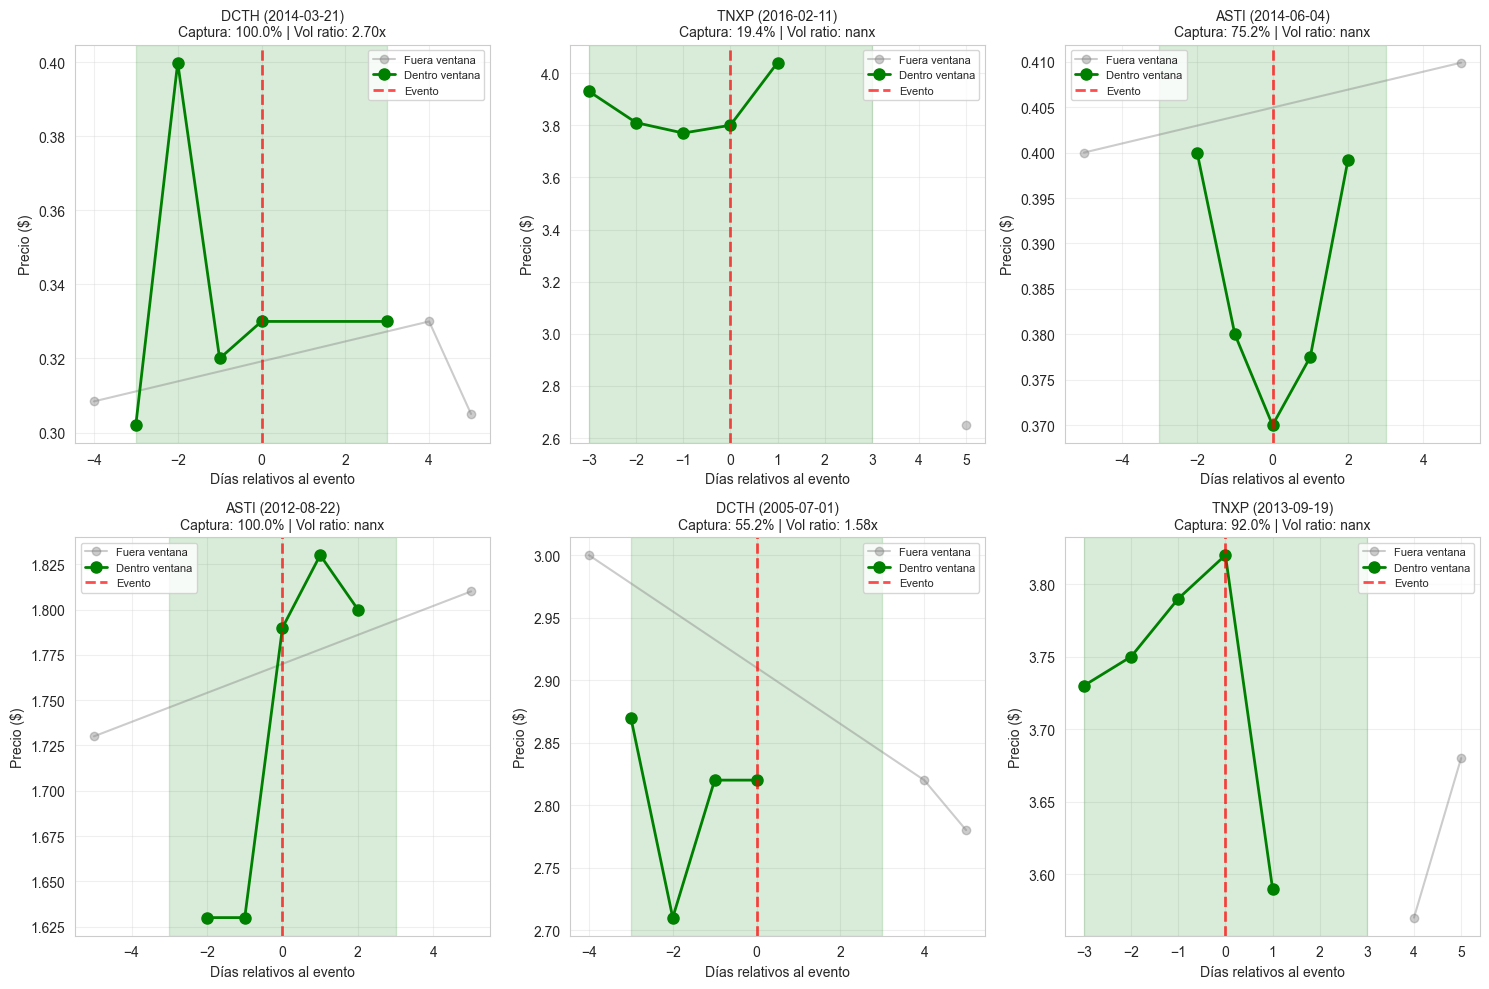


ESTADÍSTICAS DE CAPTURA: E1_VolExplosion
Ventana sugerida: [-3, +3]
  Captura de rango (%):
    - Media:   73.6%
    - Mediana: 83.6%
    - Min:     19.4%
    - Max:     100.0%

  Volatilidad dentro/fuera:
    - Media:   2.14x
    - Mediana: 2.14x

✓ Gráfico guardado: validation_E1_VolExplosion.png


✓ Validación visual completada


In [10]:
def get_daily_closes(ticker: str, start_date, end_date):
    """
    Obtiene precios de cierre diarios para un rango de fechas.
    Devuelve: list of (date, close_price)
    """
    prices = []
    current = start_date
    
    while current <= end_date:
        bars = load_dib_bars_day(ticker, current)
        if bars is not None and bars.height > 0:
            close_price = bars['c'][-1]  # Último cierre del día
            prices.append((current, close_price))
        current += timedelta(days=1)
    
    return prices


def visualize_window_capture(event_code: str, window: tuple, n_examples: int = 6):
    """
    Visualiza ejemplos reales de eventos con ventana superpuesta.
    Calcula % de movimiento capturado.
    """
    if window is None:
        print(f"❌ {event_code}: Sin ventana sugerida")
        return
    
    pre, post = window
    
    # Obtener ocurrencias del evento
    subset = wl_expanded.filter(pl.col('event_code') == event_code)
    
    # Tomar muestra aleatoria
    if subset.height > n_examples:
        subset = subset.sample(n_examples, seed=123)
    else:
        n_examples = subset.height
    
    # Configurar grid de subplots
    n_cols = 3
    n_rows = (n_examples + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_examples > 1 else [axes]
    
    capture_stats = []
    
    for idx, row in enumerate(subset.iter_rows(named=True)):
        if idx >= n_examples:
            break
            
        ticker = row['ticker']
        t0 = row['date']
        
        # Cargar precios desde t-5 hasta t+5 (ventana amplia para contexto)
        start = t0 - timedelta(days=5)
        end = t0 + timedelta(days=5)
        prices = get_daily_closes(ticker, start, end)
        
        if len(prices) < 5:  # Muy pocos datos
            continue
        
        # Separar fechas y precios
        dates = [p[0] for p in prices]
        closes = [p[1] for p in prices]
        
        # Calcular días relativos al evento
        rel_days = [(d - t0).days for d in dates]
        
        # Identificar puntos dentro de ventana sugerida
        in_window = [(pre <= rd <= post) for rd in rel_days]
        
        # Calcular captura de movimiento
        all_prices = closes
        window_prices = [p for p, in_w in zip(closes, in_window) if in_w]
        
        if len(window_prices) < 2 or len(all_prices) < 2:
            continue
        
        # Rango total vs rango capturado
        total_range = max(all_prices) - min(all_prices)
        window_range = max(window_prices) - min(window_prices)
        capture_pct = (window_range / total_range * 100) if total_range > 0 else 0
        
        # Volatilidad dentro vs fuera
        prices_in = [p for p, in_w in zip(closes, in_window) if in_w]
        prices_out = [p for p, in_w in zip(closes, in_window) if not in_w]
        
        vol_in = np.std(np.diff(prices_in)) if len(prices_in) > 1 else 0
        vol_out = np.std(np.diff(prices_out)) if len(prices_out) > 1 else 0
        vol_ratio = vol_in / vol_out if vol_out > 0 else np.nan
        
        capture_stats.append({
            'ticker': ticker,
            'date': t0,
            'capture_pct': capture_pct,
            'vol_ratio': vol_ratio
        })
        
        # Graficar
        ax = axes[idx]
        
        # Precios fuera de ventana (gris)
        out_days = [rd for rd, in_w in zip(rel_days, in_window) if not in_w]
        out_prices = [p for p, in_w in zip(closes, in_window) if not in_w]
        ax.plot(out_days, out_prices, 'o-', color='gray', alpha=0.4, label='Fuera ventana')
        
        # Precios dentro de ventana (verde/rojo)
        in_days = [rd for rd, in_w in zip(rel_days, in_window) if in_w]
        in_prices = [p for p, in_w in zip(closes, in_window) if in_w]
        ax.plot(in_days, in_prices, 'o-', color='green', linewidth=2, markersize=8, label='Dentro ventana')
        
        # Marcar día evento
        ax.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Evento')
        
        # Sombrear ventana
        ax.axvspan(pre, post, alpha=0.15, color='green')
        
        # Título con estadísticas
        ax.set_title(f"{ticker} ({t0})\nCaptura: {capture_pct:.1f}% | Vol ratio: {vol_ratio:.2f}x", 
                     fontsize=10)
        ax.set_xlabel('Días relativos al evento')
        ax.set_ylabel('Precio ($)')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
    
    # Ocultar axes vacíos
    for idx in range(len(subset), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'validation_{event_code}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Estadísticas agregadas
    if capture_stats:
        df_stats = pd.DataFrame(capture_stats)
        print(f"\n{'='*70}")
        print(f"ESTADÍSTICAS DE CAPTURA: {event_code}")
        print(f"Ventana sugerida: [{pre:+d}, {post:+d}]")
        print(f"{'='*70}")
        print(f"  Captura de rango (%):")
        print(f"    - Media:   {df_stats['capture_pct'].mean():.1f}%")
        print(f"    - Mediana: {df_stats['capture_pct'].median():.1f}%")
        print(f"    - Min:     {df_stats['capture_pct'].min():.1f}%")
        print(f"    - Max:     {df_stats['capture_pct'].max():.1f}%")
        print(f"\n  Volatilidad dentro/fuera:")
        print(f"    - Media:   {df_stats['vol_ratio'].mean():.2f}x")
        print(f"    - Mediana: {df_stats['vol_ratio'].median():.2f}x")
        print(f"{'='*70}")
        print(f"\n✓ Gráfico guardado: validation_{event_code}.png\n")
    
    return capture_stats


# Ejecutar validación para cada evento
print("\n" + "="*80)
print("VALIDACIÓN VISUAL: Captura de Movimiento Real")
print("="*80)

all_stats = {}
for event, window in suggested_windows.items():
    stats = visualize_window_capture(event, window, n_examples=6)
    all_stats[event] = stats

print("\n" + "="*80)
print("✓ Validación visual completada")
print("="*80)

## 8. VALIDACIÓN VISUAL: ¿Las ventanas capturan realmente el movimiento?

**CRÍTICO**: Necesitamos VERIFICAR que las ventanas sugeridas realmente capturan el movimiento de precio, no solo confiar en MI.

Este análisis muestra:
1. Gráficos de precio real con ventana superpuesta
2. % del movimiento total capturado por la ventana
3. Comparación de volatilidad dentro vs fuera de ventana
4. Ejemplos aleatorios para inspección visual